<h1> Final project

<h1> Importing relevant libraries

In [19]:
# Import data and package we need
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 300)
import numpy as np
import re
import string
import sklearn.metrics
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

<h1> Importing Data

In [22]:
train_data = pd.read_csv("/content/agnews_train.csv")
test_data = pd.read_csv("/content/agnews_test.csv")

<h1> EDA and Get Insights

In [23]:
# total data
print(train_data.shape)
print(test_data.shape)

(109999, 7)
(10000, 7)


In [24]:
# data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109999 entries, 0 to 109998
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text          109999 non-null  object
 1   label         109999 non-null  object
 2   label_int     109999 non-null  int64 
 3   science_int   109999 non-null  int64 
 4   sports_int    109999 non-null  int64 
 5   world_int     109999 non-null  int64 
 6   business_int  109999 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 5.9+ MB


In [25]:
# categories distribution - training
train_data['label'].value_counts()

Sports      27542
Business    27504
World       27491
Science     27462
Name: label, dtype: int64

In [26]:
# categories distribution - training
test_data['label'].value_counts()

Science     2537
World       2509
Business    2496
Sports      2458
Name: label, dtype: int64

<h1>Data Cleaning

In [27]:
# removing punctuation down character
def removePunctuationDown(strs):
    remove = '!#$%&\()+,-./:;<=>?@[\\]_{|}~'
    pattern = r"[{}]".format(remove)
    h = re.sub(pattern, " ", strs)
    return h

# removing punctuation up character
def removePunctuationUp(strs):
    remove = ',"\^`*'
    # remove = ',"\'^`*'
    pattern = r"[{}]".format(remove)
    h = re.sub(pattern, "", strs)
    return h

# replace other special character
def replace(strs):
    strs = strs.replace('\\t',' ').replace('\\n',' ').replace('\\u',' ').replace('\\',' ')
    strs = strs.replace('\n',' ')
    strs = strs.replace('\t','')
    strs = strs.encode('utf-8').decode('ascii', 'ignore')
    return strs

# remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                               #convert data input to Unicode
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

<h1> Custom Cleaning

In [28]:
# Apply Cleaning Data
train_data['news'] = [i.lower() for i in train_data.text] #lower case
train_data['remove_emoji'] = train_data['news'].apply(remove_emoji) #remov emoji
train_data['hastags'] = [re.findall(r'\B#\w*[a-zA-Z0-9]+\w*', i) for i in train_data.remove_emoji] #save hastags
train_data['remove_email'] = [re.sub(r'\S*@\S*\s?','',i) for i in train_data.remove_emoji] #remove email
train_data['remove_hashtag'] = [re.sub("#[A-Za-z0-9_]+",'',i) for i in train_data.remove_emoji] #remove hastags
train_data['remove_special_character'] = train_data['remove_hashtag'].replace(r'http\s+|www.\s+','',regex=True).replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True) #remove link
train_data['remove_special_character'] = [re.sub(r'&lt;/?[a-z]+&gt;','',i) for i in train_data.remove_special_character] #remove_special_character
train_data['remove_special_character'] = [re.sub('<.*?>+', '', i) for i in train_data.remove_special_character] #remove special character
train_data['text_clean'] = [removePunctuationDown(i) for i in train_data.remove_special_character] #remove punc down
train_data['text_clean'] = [removePunctuationUp(i) for i in train_data.text_clean] #remove punc up
train_data['text_clean'] = [replace(j) for j in train_data.text_clean] #remove \n \t

In [29]:
test_data['news'] = [i.lower() for i in test_data.text] #lower case
test_data['remove_emoji'] = test_data['news'].apply(remove_emoji) #remov emoji
test_data['hastags'] = [re.findall(r'\B#\w*[a-zA-Z0-9]+\w*', i) for i in test_data.remove_emoji] #save hastags
test_data['remove_email'] = [re.sub(r'\S*@\S*\s?','',i) for i in test_data.remove_emoji] #remove email
test_data['remove_hashtag'] = [re.sub("#[A-Za-z0-9_]+",'',i) for i in test_data.remove_emoji] #remove hastags
test_data['remove_special_character'] = test_data['remove_hashtag'].replace(r'http\s+|www.\s+','',regex=True).replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True) #remove link
test_data['remove_special_character'] = [re.sub(r'&lt;/?[a-z]+&gt;','',i) for i in test_data.remove_special_character] #remove_special_character
test_data['remove_special_character'] = [re.sub('<.*?>+', '', i) for i in test_data.remove_special_character] #remove special character
test_data['text_clean'] = [removePunctuationDown(i) for i in test_data.remove_special_character] #remove punc down
test_data['text_clean'] = [removePunctuationUp(i) for i in test_data.text_clean] #remove punc up
test_data['text_clean'] = [replace(j) for j in test_data.text_clean] #remove \n \t

In [30]:
# select columns
train_data = train_data[[ 'text','text_clean','science_int','sports_int','world_int','business_int','label_int']]
test_data = test_data[['text','text_clean','science_int','sports_int','world_int','business_int','label_int']]

In [31]:
train_data

,text,text_clean,science_int,sports_int,world_int,business_int,label_int
0,"John Souza, a volunteer with the Boone County chapter of the American Red Cross, is the second Columbia resident to join efforts to assist people who were affected by Tropical Storm Bonnie and Hurricane Charley.",john souza a volunteer with the boone county chapter of the american red cross is the second columbia resident to join efforts to assist people who were affected by tropical storm bonnie and hurricane charley,0,0,0,1,3
1,"Spain needs only to beat an under-strength French team to secure its place in the Davis Cup tennis final, while Britain looks to the experience of Tim Henman and Greg Rusedski in its World Group play-off with Austria this weekend.",spain needs only to beat an under strength french team to secure its place in the davis cup tennis final while britain looks to the experience of tim henman and greg rusedski in its world group play off with austria this weekend,0,1,0,0,1
2,"PANAMA CITY, Panama -- When the United States gave Panama control over its canal, many observers predicted that the international waterway would be plagued by problems at best and chaos at worst.",panama city panama when the united states gave panama control over its canal many observers predicted that the international waterway would be plagued by problems at best and chaos at worst,0,0,1,0,2
3,"Gilbert Arenas, Jarvis Hayes and Anthony Peeler return from minor injuries to play in the Wizards' 97-85 victory over the Bobcats.",gilbert arenas jarvis hayes and anthony peeler return from minor injuries to play in the wizards' 97 85 victory over the bobcats,0,1,0,0,1
4,"MEMPHIS, Tenn. -- Kobe Bryant had his worst shooting night of the season Wednesday in the Lakers #39; 110-87 loss to the Grizzlies, and worse yet, he needed nearly 45 minutes of postgame treatment for plantar fasciitis in his left foot.",memphis tenn kobe bryant had his worst shooting night of the season wednesday in the lakers 110 87 loss to the grizzlies and worse yet he needed nearly 45 minutes of postgame treatment for plantar fasciitis in his left foot,0,1,0,0,1
...,...,...,...,...,...,...,...
109994,WASHINGTON-NextWave Telecom Inc. has until Nov. 3 to detail how it plans to emerge from bankruptcy after the bankrupt PCS bidder was given another filing extension.,washington nextwave telecom inc has until nov 3 to detail how it plans to emerge from bankruptcy after the bankrupt pcs bidder was given another filing extension,1,0,0,0,0
109995,US military officials in Iraq say two US soldiers were killed in separate incidents late Wednesday. One soldier was killed and two others were wounded in an attack on their convoy near the insurgent stronghold of Fallujah.,us military officials in iraq say two us soldiers were killed in separate incidents late wednesday one soldier was killed and two others were wounded in an attack on their convoy near the insurgent stronghold of fallujah,0,0,1,0,2
109996,"ST. GEORGE'S, Grenada - Hurricane Ivan made a direct hit on Grenada, killing at least three people as it turned concrete homes into piles of rubble and hurled the island's landmark red zinc roofs through the air...",st george's grenada hurricane ivan made a direct hit on grenada killing at least three people as it turned concrete homes into piles of rubble and hurled the island's landmark red zinc roofs through the air,0,0,1,0,2
109997,"The Expos president has lists prepared and plans in place to close up shop in Montreal and rebuild the franchise in Washington. He #39;ll begin to act once Major League Baseball confirms the club #39;s move, something which could happen as soon as Thursday.",the expos president has lists prepared and plans in place to close up shop in montreal and rebuild the franchise in washington he ll begin to act once major league baseball confirms the club s move something which could happen as soon as thursday,0,1,0,0,1


<h1> Binary Classification Models

In [32]:
from sklearn.pipeline import Pipeline
categories = {0: 'Science',
              1: 'Sports',
              2: 'World',
              3: 'Business'}

### Naive-Bayes

In [33]:
def nb_model(category: str, train = train_data, test = test_data, categories = categories):

  model_nb = Pipeline([
                          ('vect', CountVectorizer(stop_words='english')),
                          ('tfidf', TfidfTransformer()),
                          ('clf', MultinomialNB()),
                          ])
  
  column = category.lower() + '_int'

  model_nb.fit(train.text_clean, train[column])

  pred_nb = model_nb.predict(test.text_clean)

  print(category, ' Evaluation \n')
  print(classification_report(test[column], 
                              pred_nb,
                              target_names=['Yes','No'], 
                              zero_division=0))

In [34]:
nb_model('science')

science  Evaluation 

              precision    recall  f1-score   support

         Yes       0.93      0.97      0.95      7463
          No       0.91      0.78      0.84      2537

    accuracy                           0.92     10000
   macro avg       0.92      0.88      0.90     10000
weighted avg       0.92      0.92      0.92     10000



In [35]:
nb_model('sports')

sports  Evaluation 

              precision    recall  f1-score   support

         Yes       0.98      0.99      0.99      7542
          No       0.97      0.95      0.96      2458

    accuracy                           0.98     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000



In [36]:
nb_model('world')

world  Evaluation 

              precision    recall  f1-score   support

         Yes       0.94      0.98      0.96      7491
          No       0.94      0.82      0.88      2509

    accuracy                           0.94     10000
   macro avg       0.94      0.90      0.92     10000
weighted avg       0.94      0.94      0.94     10000



In [37]:
nb_model('business')

business  Evaluation 

              precision    recall  f1-score   support

         Yes       0.93      0.97      0.95      7504
          No       0.89      0.78      0.83      2496

    accuracy                           0.92     10000
   macro avg       0.91      0.88      0.89     10000
weighted avg       0.92      0.92      0.92     10000



### SGD Classifier

In [38]:
def sgd_model(category: str, train = train_data, test = test_data, categories = categories):

  model_sgd = Pipeline([
                          ('vect', CountVectorizer(stop_words='english')),
                          ('tfidf', TfidfTransformer()),
                          ('clf', SGDClassifier(loss='hinge', penalty='l2',
                             alpha=1e-6, random_state=42,
                                               max_iter=100, tol=None))
                          ])
  
  column = category.lower() + '_int'

  model_sgd.fit(train.text_clean, train[column])

  pred_nb = model_sgd.predict(test.text_clean)

  print(category, ' Evaluation \n')
  print(classification_report(test[column], 
                              pred_nb,
                              target_names=['Yes','No'], 
                              zero_division=0))

In [39]:
sgd_model('science')

science  Evaluation 

              precision    recall  f1-score   support

         Yes       0.95      0.95      0.95      7463
          No       0.86      0.85      0.86      2537

    accuracy                           0.93     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.93      0.93      0.93     10000



In [40]:
sgd_model('sports')

sports  Evaluation 

              precision    recall  f1-score   support

         Yes       0.98      0.99      0.98      7542
          No       0.95      0.95      0.95      2458

    accuracy                           0.98     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000



In [41]:
sgd_model('world')

world  Evaluation 

              precision    recall  f1-score   support

         Yes       0.96      0.97      0.96      7491
          No       0.89      0.87      0.88      2509

    accuracy                           0.94     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.94      0.94      0.94     10000



In [42]:
sgd_model('business')

business  Evaluation 

              precision    recall  f1-score   support

         Yes       0.95      0.95      0.95      7504
          No       0.85      0.86      0.85      2496

    accuracy                           0.93     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.93      0.93      0.93     10000



<h1>Binary Models with Grid Search

In [43]:
from sklearn.model_selection import GridSearchCV

def crossvalidation_report_df(grid_cv): 
    """Convenience  function. 
    
    Creates a simple dataframe that reports the results of a 
    cros-validation experiment. The input grid_cv must be fit. 
    
    Returns a dataframe, sorted by rank of experiment. 
    """
    # pick columns that define each experiment (start with param)
    # and the columns that report mean_test and rank_test results
    cols = [c for c in grid_cv.cv_results_ if (c.startswith('param') or 
                                               c in ['mean_test_score', 'rank_test_score'])]

    # sort original df by rank, and select columns
    return pd.DataFrame(grid_cv.cv_results_).sort_values(by='rank_test_score')[cols]

<h2> Naive Bayes

In [44]:
def nb_model_gcv(category: str, train = train_data, test = test_data, categories = categories):

  model_nb = Pipeline([
                          ('vect', CountVectorizer(stop_words='english')),
                          ('tfidf', TfidfTransformer()),
                          ('clf', MultinomialNB()),
                          ])
  
  sgd_grid_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)]
  }

  # we create the grid
  nb_grid= GridSearchCV(model_nb, sgd_grid_parameters, verbose=1)

  column = category.lower() + '_int'

  nb_grid.fit(train.text_clean, train[column])

  #pred_nb = model_nb.predict(test.text_clean)

  #print(category, ' Evaluation \n')
  #print(classification_report(test[column], 
  #                            pred_nb,
  #                            target_names=['Yes','No'], 
  #                            zero_division=0))

  print(crossvalidation_report_df(nb_grid))


In [45]:
nb_model_gcv('science')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
  param_vect__ngram_range                         params  mean_test_score  rank_test_score
0                  (1, 1)  {'vect__ngram_range': (1, 1)}         0.923045                1
1                  (1, 2)  {'vect__ngram_range': (1, 2)}         0.880990                2
2                  (1, 3)  {'vect__ngram_range': (1, 3)}         0.868308                3


In [46]:
nb_model_gcv('sports')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
  param_vect__ngram_range                         params  mean_test_score  rank_test_score
0                  (1, 1)  {'vect__ngram_range': (1, 1)}         0.975982                1
1                  (1, 2)  {'vect__ngram_range': (1, 2)}         0.952063                2
2                  (1, 3)  {'vect__ngram_range': (1, 3)}         0.939627                3


In [47]:
nb_model_gcv('world')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
  param_vect__ngram_range                         params  mean_test_score  rank_test_score
0                  (1, 1)  {'vect__ngram_range': (1, 1)}         0.946727                1
1                  (1, 2)  {'vect__ngram_range': (1, 2)}         0.923245                2
2                  (1, 3)  {'vect__ngram_range': (1, 3)}         0.913627                3


In [48]:
nb_model_gcv('business')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
  param_vect__ngram_range                         params  mean_test_score  rank_test_score
0                  (1, 1)  {'vect__ngram_range': (1, 1)}         0.920063                1
1                  (1, 2)  {'vect__ngram_range': (1, 2)}         0.890835                2
2                  (1, 3)  {'vect__ngram_range': (1, 3)}         0.880135                3


<h3> SGD

In [49]:
def sgd_model_gcv(category: str, train = train_data, test = test_data, categories = categories):

  model_nb = Pipeline([
                          ('vect', CountVectorizer(stop_words='english')),
                          ('tfidf', TfidfTransformer()),
                          ('clf', MultinomialNB()),
                          ])
  
  sgd_grid_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': (1e-3, 1e-6, 1e-9, 1e-12)
  }

  # we create the grid
  sgd_grid= GridSearchCV(model_nb, sgd_grid_parameters, verbose=1)

  column = category.lower() + '_int'

  sgd_grid.fit(train.text_clean, train[column])

  #pred_nb = model_nb.predict(test.text_clean)

  #print(category, ' Evaluation \n')
  #print(classification_report(test[column], 
  #                            pred_nb,
  #                            target_names=['Yes','No'], 
  #                            zero_division=0))

  print(crossvalidation_report_df(sgd_grid))


In [50]:
sgd_model_gcv('science')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr

   param_clf__alpha param_vect__ngram_range                                              params  mean_test_score  rank_test_score
1             0.001                  (1, 2)  {'clf__alpha': 0.001, 'vect__ngram_range': (1, 2)}         0.936736                1
2             0.001                  (1, 3)  {'clf__alpha': 0.001, 'vect__ngram_range': (1, 3)}         0.936527                2
5          0.000001                  (1, 3)  {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}         0.931854                3
4          0.000001                  (1, 2)  {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 2)}         0.931199                4
8               0.0                  (1, 3)  {'clf__alpha': 1e-09, 'vect__ngram_range': (1, 3)}         0.929508                5
11              0.0                  (1, 3)  {'clf__alpha': 1e-12, 'vect__ngram_range': (1, 3)}         0.929090                6
7               0.0                  (1, 2)  {'clf__alpha': 1e-09, 'vect__ngram_range': (1

In [51]:
sgd_model_gcv('sports')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr

   param_clf__alpha param_vect__ngram_range                                              params  mean_test_score  rank_test_score
2             0.001                  (1, 3)  {'clf__alpha': 0.001, 'vect__ngram_range': (1, 3)}         0.981963                1
1             0.001                  (1, 2)  {'clf__alpha': 0.001, 'vect__ngram_range': (1, 2)}         0.981818                2
5          0.000001                  (1, 3)  {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}         0.978191                3
4          0.000001                  (1, 2)  {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 2)}         0.977727                4
8               0.0                  (1, 3)  {'clf__alpha': 1e-09, 'vect__ngram_range': (1, 3)}         0.976509                5
11              0.0                  (1, 3)  {'clf__alpha': 1e-12, 'vect__ngram_range': (1, 3)}         0.976127                6
0             0.001                  (1, 1)  {'clf__alpha': 0.001, 'vect__ngram_range': (1

In [52]:
sgd_model_gcv('world')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr

   param_clf__alpha param_vect__ngram_range                                              params  mean_test_score  rank_test_score
1             0.001                  (1, 2)  {'clf__alpha': 0.001, 'vect__ngram_range': (1, 2)}         0.952072                1
2             0.001                  (1, 3)  {'clf__alpha': 0.001, 'vect__ngram_range': (1, 3)}         0.951427                2
5          0.000001                  (1, 3)  {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}         0.948309                3
4          0.000001                  (1, 2)  {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 2)}         0.947936                4
8               0.0                  (1, 3)  {'clf__alpha': 1e-09, 'vect__ngram_range': (1, 3)}         0.946718                5
11              0.0                  (1, 3)  {'clf__alpha': 1e-12, 'vect__ngram_range': (1, 3)}         0.946472                6
7               0.0                  (1, 2)  {'clf__alpha': 1e-09, 'vect__ngram_range': (1

In [53]:
sgd_model_gcv('business')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr

   param_clf__alpha param_vect__ngram_range                                              params  mean_test_score  rank_test_score
2             0.001                  (1, 3)  {'clf__alpha': 0.001, 'vect__ngram_range': (1, 3)}         0.931636                1
1             0.001                  (1, 2)  {'clf__alpha': 0.001, 'vect__ngram_range': (1, 2)}         0.930981                2
5          0.000001                  (1, 3)  {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}         0.926708                3
4          0.000001                  (1, 2)  {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 2)}         0.925845                4
8               0.0                  (1, 3)  {'clf__alpha': 1e-09, 'vect__ngram_range': (1, 3)}         0.924863                5
11              0.0                  (1, 3)  {'clf__alpha': 1e-12, 'vect__ngram_range': (1, 3)}         0.924508                6
7               0.0                  (1, 2)  {'clf__alpha': 1e-09, 'vect__ngram_range': (1

<h1> Multi-class Classification Models

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [56]:
# Naive-Bayes Model
mr_naivebayes = Pipeline([
                          ('vect', CountVectorizer(stop_words='english')),
                          ('tfidf', TfidfTransformer()),
                          ('clf', MultinomialNB()),
])
mr_naivebayes.fit(train_data.text_clean, train_data.label_int)

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [57]:
#SGD classifier
mr_sgd = Pipeline([
                   ('vect', CountVectorizer(stop_words='english')),
                   ('tfidf', TfidfTransformer(use_idf=True)),
                   ('clf', SGDClassifier(loss='hinge', penalty='l2',
                             alpha=1e-6, random_state=42,
                                               max_iter=100, tol=None)),
])
mr_sgd.fit(train_data.text_clean, train_data.label_int)

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=1e-06, max_iter=100, random_state=42,
                               tol=None))])

In [ ]:
mr_lg= Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])
mr_lg.fit(train_data.text_clean, train_data.label_int)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])

## Multi-Class Model Evaluation 

In [ ]:
from sklearn.metrics import classification_report

test_y = test_data.label_int

In [ ]:
# Naive-Bayes evaluation

y_pred_nb = mr_naivebayes.predict(test_data.text_clean)

print(classification_report(test_y, 
                            y_pred_nb,
                            target_names=['Science', 'Sports', 'World', 'Business'], 
                            zero_division=0))

              precision    recall  f1-score   support

     Science       0.88      0.86      0.87      2537
      Sports       0.95      0.98      0.96      2458
       World       0.89      0.89      0.89      2509
    Business       0.86      0.87      0.86      2496

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
# Sgd evaluation

y_pred_sgd = mr_sgd.predict(test_data.text_clean)

print(classification_report(test_y, 
                            y_pred_sgd,
                            target_names=['Science', 'Sports', 'World', 'Business'], 
                            zero_division=0))


              precision    recall  f1-score   support

     Science       0.87      0.87      0.87      2537
      Sports       0.95      0.96      0.96      2458
       World       0.90      0.88      0.89      2509
    Business       0.85      0.87      0.86      2496

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
# logistic evaluation 
y_pred_lg = mr_lg.predict(test_data.text_clean)

print(classification_report(test_y, 
                            y_pred_sgd,
                            target_names=['Science', 'Sports', 'World', 'Business'], 
                            zero_division=0))

              precision    recall  f1-score   support

     Science       0.87      0.87      0.87      2537
      Sports       0.95      0.96      0.96      2458
       World       0.90      0.88      0.89      2509
    Business       0.85      0.87      0.86      2496

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
# Random froest evaluation 
y_pred_rf = mr_rf.predict(test_data.text_clean)

print(classification_report(test_y, 
                            y_pred_sgd,
                            target_names=['Science', 'Sports', 'World', 'Business'], 
                            zero_division=0))

# Learning curve

In [54]:
import yellowbrick
from yellowbrick.model_selection import learning_curve
from mlxtend.plotting import plot_learning_curves

In [58]:
naivebayes = mr_naivebayes.fit(train_data.text_clean, train_data.label_int)
sgd = mr_sgd.fit(train_data.text_clean, train_data.label_int)
#lg = mr_lg.fit(train_data.text_clean, train_data.label_int)

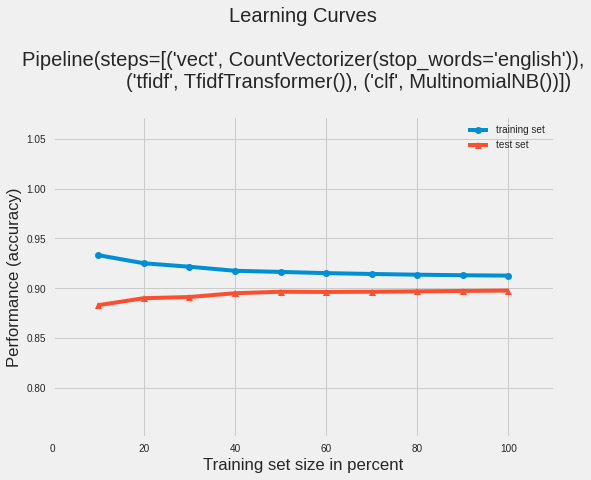

In [59]:
plot_learning_curves(train_data.text_clean, train_data.label_int, test_data.text_clean, test_data.label_int,naivebayes, scoring = 'accuracy')
plt.show()

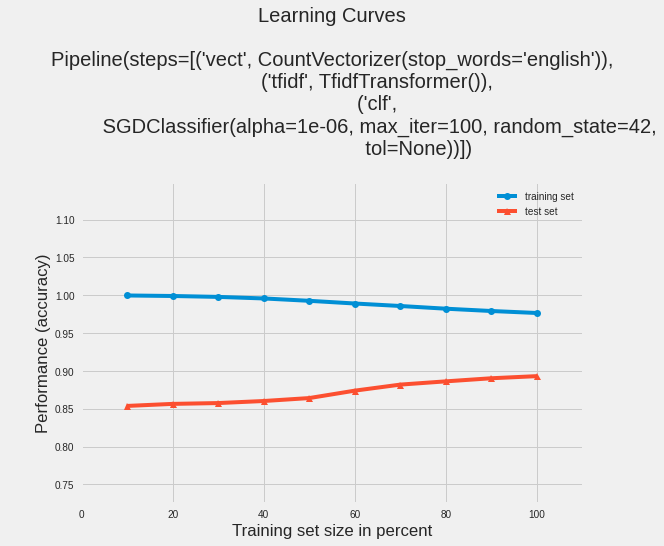

In [60]:
plot_learning_curves(train_data.text_clean, train_data.label_int, test_data.text_clean, test_data.label_int,sgd, scoring = 'accuracy')
plt.show()

In [ ]:
plot_learning_curves(train_data.text_clean, train_data.label_int, test_data.text_clean, test_data.label_int,lg)
plt.show()